In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [14]:
dataset = '/content/keypoint.csv'
model_save_path = '/content/keypoint_classifier.hdf5'

In [15]:
NUM_CLASSES = 5

In [16]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [17]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [20]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/8 [==>...........................] - ETA: 7s - loss: 2.0659 - accuracy: 0.1875
Epoch 1: saving model to /content/keypoint_classifier.hdf5
8/8 [==============================] - 2s 64ms/step - loss: 1.8846 - accuracy: 0.2159 - val_loss: 1.7522 - val_accuracy: 0.2079
Epoch 2/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.8757 - accuracy: 0.2266
Epoch 2: saving model to /content/keypoint_classifier.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 21ms/step - loss: 1.7448 - accuracy: 0.2280 - val_loss: 1.6152 - val_accuracy: 0.2079
Epoch 3/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.6790 - accuracy: 0.2344
Epoch 3: saving model to /content/keypoint_classifier.hdf5
8/8 [==============================] - 0s 17ms/step - loss: 1.6406 - accuracy: 0.2412 - val_loss: 1.5132 - val_accuracy: 0.3861
Epoch 4/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.5971 - accuracy: 0.2344
Epoch 4: saving model to /content/keypoint_classifier.hdf5
8/8 [==============================] - 0s 16ms/step - loss: 1.5619 - accuracy: 0.2511 - val_loss: 1.4478 - val_accuracy: 0.3861
Epoch 5/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.5080 - accuracy: 0.2812
Epoch 5: saving model to /content/keypoint_classifier.hdf5
8/8 [==============================] - 0s 14ms/step - loss: 1.4906 - accuracy: 0.3062 - val_loss: 1.3940 - val_accuracy: 0.5644
Epoch 6/1000
1/8 [==>........

In [23]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 9ms/step - loss: 0.0422 - accuracy: 0.9835


In [24]:
model = tf.keras.models.load_model(model_save_path)

In [25]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 93ms/step
[9.9998474e-01 2.7802685e-06 3.5169030e-13 2.1760874e-08 1.2483564e-05]
0


10/10 [==============================] - 0s 6ms/step


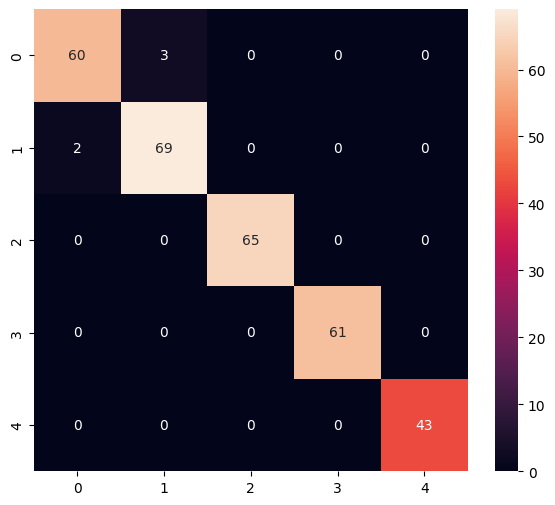

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        63
           1       0.96      0.97      0.97        71
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        61
           4       1.00      1.00      1.00        43

    accuracy                           0.98       303
   macro avg       0.99      0.98      0.99       303
weighted avg       0.98      0.98      0.98       303



In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [27]:
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tflite_save_path = '/content/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

In [29]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [30]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [31]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [32]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 9.14 ms


In [33]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.99984622e-01 2.78026846e-06 3.51688920e-13 2.17609148e-08
 1.24835615e-05]
0
